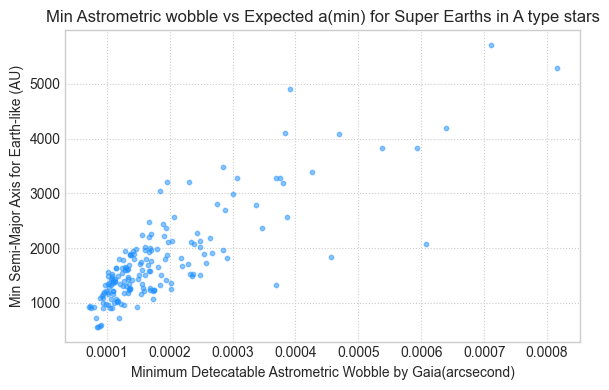

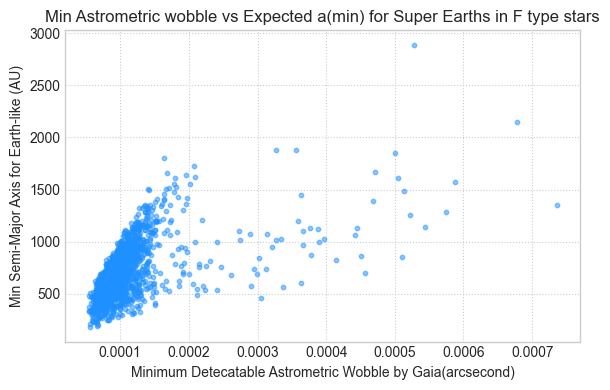

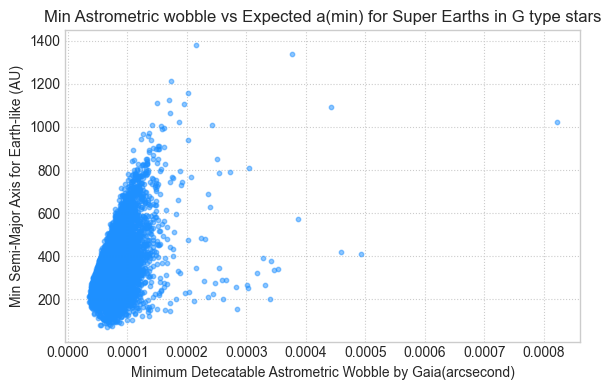

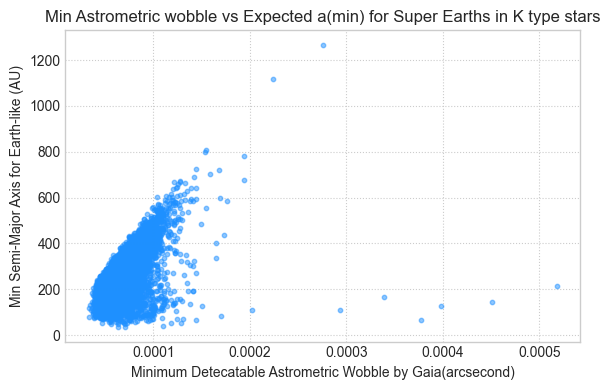

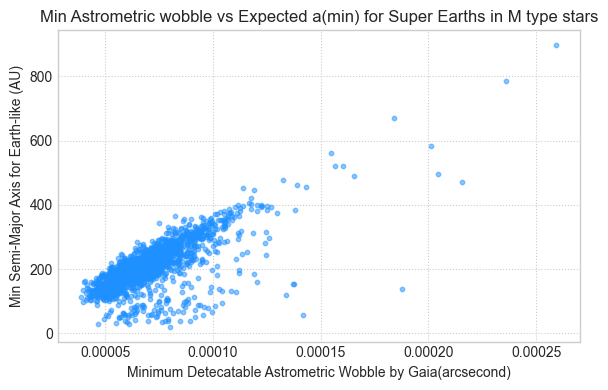

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
types = ['A','F','G','K','M']
for i in types:
    data = pd.read_csv(f'{i}/spectral_type_{i}.csv')
    plt.figure(figsize=(6, 4))
    plt.scatter(data['alpha_min_arcsec'], data['Super_Earth'], s=10, alpha=0.5, color='dodgerblue')
    plt.xlabel("Minimum Detecatable Astrometric Wobble by Gaia(arcsecond)")
    plt.ylabel("Min Semi-Major Axis for Earth-like (AU)")
    plt.title(f"Min Astrometric wobble vs Expected a(min) for Super Earths in {i} type stars")
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()


In [81]:
import pandas as pd

dat = pd.read_csv('M/spectral_type_M.csv')
#finding the minimum distance and max
print (f'The range is {dat['distance_pc'].min()} and {dat['distance_pc'].max()}')

The range is 6.164578207302766 and 99.99841754895576


C:\Users\kisho\AppData\Local\Temp\ipykernel_40560\2191453061.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_per_bin = df.groupby('distance_bin')['alpha_min_arcsec'].median().reset_index()


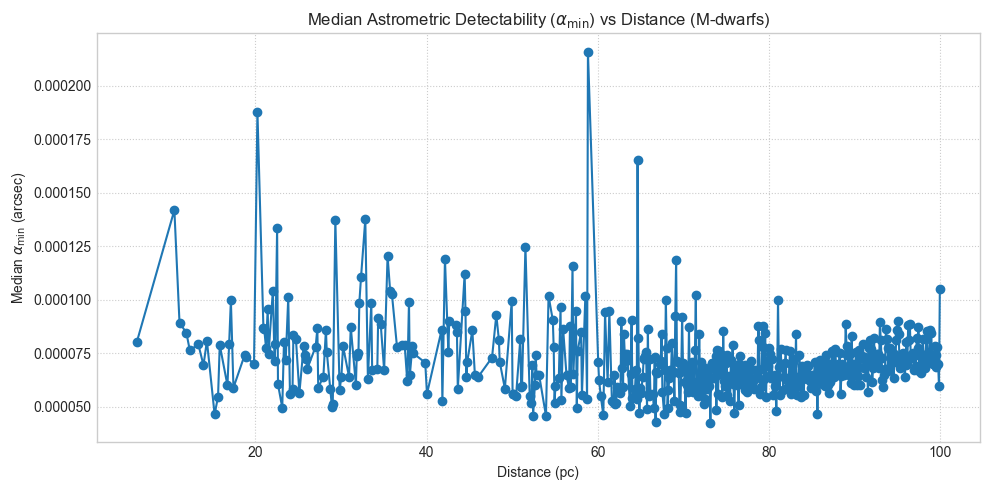

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your M-dwarf dataset
df = pd.read_csv('M/spectral_type_M.csv')

df = df [['mass','distance_pc', 'alpha_min_arcsec']]

# Filter out invalid data
df = df[df['alpha_min_arcsec'].notna() & (df['alpha_min_arcsec'] > 0)]

# Define bin edges (6 to 100 pc in 0.1 pc intervals)
bins = np.arange(6, 100.1, 0.1)

# Bin labels (midpoints of each bin)
bin_labels = (bins[:-1] + bins[1:]) / 2

# Add a new column to assign each row to a bin
df['distance_bin'] = pd.cut(df['distance_pc'], bins=bins, labels=bin_labels, include_lowest=True)

# Group by the bin and calculate the median alpha_min for each bin
median_per_bin = df.groupby('distance_bin')['alpha_min_arcsec'].median().reset_index()

# Drop NaNs (some bins may be empty)
median_per_bin = median_per_bin.dropna()

# Rename columns for clarity
median_per_bin.columns = ['distance_pc', 'median_alpha_min_arcsec']


# Plotting (optional)
plt.figure(figsize=(10, 5))
plt.plot(median_per_bin['distance_pc'], median_per_bin['median_alpha_min_arcsec'], marker='o', linestyle='-', linewidth=1.5)
plt.xlabel('Distance (pc)')
plt.ylabel('Median $\\alpha_{\\min}$ (arcsec)')
plt.title('Median Astrometric Detectability ($\\alpha_{\\min}$) vs Distance (M-dwarfs)')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()


In [112]:
# Convert categorical bin labels to numeric (float)
median_per_bin['distance_pc'] = median_per_bin['distance_pc'].astype(float)

# Now find closest bin to 20 pc
target_distance = 20
closest_bin = median_per_bin.iloc[(median_per_bin['distance_pc'] - target_distance).abs().argsort()[:1]]

print(closest_bin)

median_at_20pc = closest_bin['median_alpha_min_arcsec'].values[0]
print(f"Median alpha_min_arcsec at ~20 pc bin: {median_at_20pc}")


     distance_pc  median_alpha_min_arcsec
138        19.85                  0.00007
Median alpha_min_arcsec at ~20 pc bin: 6.987025784575941e-05


In [104]:
import pandas as pd

DISTANCE = 20  # parsecs
MASS = 0.5 * 333000  # Solar masses to Earth masses

a_max_thresholds = {
    'Earth_like': 1,      
    'Super_Earth': 3,     
    'Sub_Neptune': 5,     
    'Neptune_like': 10    
}

alpha_min_arc_thresholds = {
    'gaia_20': 6.987025784575941e-05,
    'theia_20': 3e-7,  # proposed
    'NEAT_20': 1e-7    # proposed
}

for mission, alpha_arc in alpha_min_arc_thresholds.items():
    row = {'mission': mission, 'alpha_min_arc': alpha_arc}

    for planet, a_max in a_max_thresholds.items():
        if planet == 'Earth_like':
            mp = 1.0
        elif planet == 'Super_Earth':
            mp = 5.0
        elif planet == 'Sub_Neptune':
            mp = 7.0
        else:
            mp = 17.1

        a_min = alpha_arc * DISTANCE * (MASS / mp)
        row[f'MIN_{planet}'] = a_min
        row[f'MAX_{planet}'] = a_max
        row[f'detectable_{planet}'] = int(a_max >= a_min)

    df = pd.DataFrame([row])
    df.to_csv(f'DI/{mission}.csv', index=False)


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your M-dwarf dataset
df = pd.read_csv('M/spectral_type_M.csv')
df = df [['mass','distance_pc']]
df['mass'] = df['mass']*33600
g = df.copy()

a_max_thresholds = {
    'Earth_like': 1,      
    'Super_Earth': 3,     
    'Sub_Neptune': 5,     
    'Neptune_like': 10    
}

alpha_min_arc_thresholds = {
    'theia_20': 3e-7,  # proposed
    'NEAT_20': 1e-7    # proposed
}

for mission, alpha_arc in alpha_min_arc_thresholds.items():
    for planet, a_max in a_max_thresholds.items():
       
        if planet == 'Earth_like':
            mp = 1.0
        elif planet == 'Super_Earth':
            mp = 5.0
        elif planet == 'Sub_Neptune':
            mp = 7.0
        else:
            mp = 17.1

        a_min = alpha_arc * df['distance_pc'] * ( df['mass'] / mp)
        df[f'{planet}_detectability'] = (a_max >= a_min).astype(int)
        
    df.to_csv(f'final/{mission}_Detectability.csv')
    df = g.copy()


In [135]:
for p in alpha_min_arc_thresholds.keys():
    l = pd.read_csv(f'final/{p}_Detectability.csv')
    stars = len(l)
    for x in a_max_thresholds.keys():
        m = l.copy()
        m = m[m[f'{x}_detectability']==1]
        tru = len(m)
        l[f'{x}_DI'] = (tru/stars)*100
    l.to_csv(f'real DI/{p}.csv')